In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.metrics import mean_absolute_percentage_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/31006-ts/Data/thaitourism2.csv')
df.head()

,region,nationality,year,month,tourists
0,Africa,AfrOthers,2010,1,6553
1,Africa,AfrOthers,2010,2,5618
2,Africa,AfrOthers,2010,3,6689
3,Africa,AfrOthers,2010,4,5210
4,Africa,AfrOthers,2010,5,4537


In [ ]:
# Load supplementary data
df_s = pd.read_excel('/content/drive/MyDrive/31006-ts/Data/currency_and_temperature_data.xlsx')
df_s.head()

,year,month,average exchange rate (Convert 1 USD to Thai baht),average temperature - Bangkok (F)
0,2010,1,33.1110,80.79
1,2010,2,33.1497,84.70
2,2010,3,32.5115,85.98
3,2010,4,32.2977,88.35
4,2010,5,32.4197,87.41


In [ ]:
df_s.isna().any()

year                                                  False
month                                                 False
average exchange rate (Convert 1 USD to Thai baht)    False
average temperature - Bangkok (F)                     False
dtype: bool

In [ ]:
# Set date as the index of the data frame
df['Month'] = pd.to_datetime(df.year.astype(str) + '/' + df.month.astype(str))
df = df.set_index('Month')
df_us = df[df.nationality == 'USA']
df_us.head()

,region,nationality,year,month,tourists
Month,,,,,
2010-01-01,Americas,USA,2010,1,69238
2010-02-01,Americas,USA,2010,2,58901
2010-03-01,Americas,USA,2010,3,59667
2010-04-01,Americas,USA,2010,4,49775
2010-05-01,Americas,USA,2010,5,34061


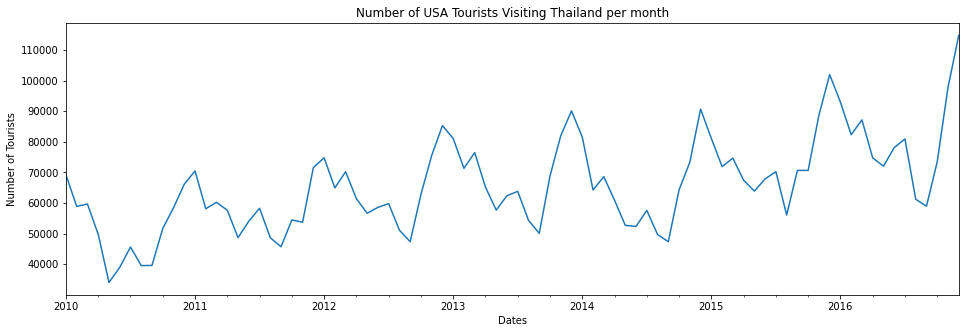

In [ ]:
# Convert index to Datetime Index and plot the time series data
df_us.index.freq = 'MS'
ax = df_us['tourists'].plot(figsize = (16,5), title = "Number of USA Tourists Visiting Thailand per month")
ax.set(xlabel='Dates', ylabel='Number of Tourists');

In [ ]:
df_sub = df_us[['tourists']]
df_sub.shape

(84, 1)

In [ ]:
# Set date as the index of the data frame
df_s['Month'] = pd.to_datetime(df_s.year.astype(str) + '/' + df_s.month.astype(str))
df_s = df_s.set_index('Month')
df_s_sub = df_s.iloc[:, 2:4]
df_s_sub.head()

,average exchange rate (Convert 1 USD to Thai baht),average temperature - Bangkok (F)
Month,,
2010-01-01,33.1110,80.79
2010-02-01,33.1497,84.70
2010-03-01,32.5115,85.98
2010-04-01,32.2977,88.35
2010-05-01,32.4197,87.41


In [ ]:
df_new = df_sub.merge(df_s_sub, how = 'inner', left_index=True, right_index=True)
df_new.head()

,tourists,average exchange rate (Convert 1 USD to Thai baht),average temperature - Bangkok (F)
Month,,,
2010-01-01,69238,33.1110,80.79
2010-02-01,58901,33.1497,84.70
2010-03-01,59667,32.5115,85.98
2010-04-01,49775,32.2977,88.35
2010-05-01,34061,32.4197,87.41


In [ ]:
# train and test split
train = df_new[:len(df_new)-12].copy()
test = df_new[len(df_new)-12:].copy()

In [ ]:
# Normalize the data
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train.shape

(72, 3)

In [ ]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 0]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_steps = 12
n_features = 3
X, y = split_sequences(scaled_train, n_steps)
for i in range(len(X))[0:2]:
	print(X[i], y[i])

[[0.51807069 0.58207407 0.32970451]
 [0.36583211 0.58764891 0.63374806]
 [0.3771134  0.49571443 0.73328149]
 [0.23142857 0.46491595 0.91757387]
 [0.         0.48249038 0.844479  ]
 [0.07253314 0.4893617  0.75272162]
 [0.17051546 0.46611158 0.61197512]
 [0.08110457 0.38545643 0.49533437]
 [0.08182622 0.25687492 0.49766719]
 [0.259838   0.12245927 0.40124417]
 [0.35930781 0.11917487 0.42457232]
 [0.47300442 0.15232141 0.34292379]] 0.5365832106038291
[[0.36583211 0.58764891 0.63374806]
 [0.3771134  0.49571443 0.73328149]
 [0.23142857 0.46491595 0.91757387]
 [0.         0.48249038 0.844479  ]
 [0.07253314 0.4893617  0.75272162]
 [0.17051546 0.46611158 0.61197512]
 [0.08110457 0.38545643 0.49533437]
 [0.08182622 0.25687492 0.49766719]
 [0.259838   0.12245927 0.40124417]
 [0.35930781 0.11917487 0.42457232]
 [0.47300442 0.15232141 0.34292379]
 [0.53658321 0.21433613 0.19051322]] 0.35460972017673054


In [ ]:
model = Sequential()
model.add(LSTM(50, activation = 'relu', input_shape=(n_steps, n_features), return_sequences = True))
model.add(LSTM(50, activation = 'relu', return_sequences = False))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 50)            10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X, y, epochs=200)

Epoch 1/200
2/2 [==============================] - 2s 18ms/step - loss: 0.2144
Epoch 2/200
2/2 [==============================] - 0s 16ms/step - loss: 0.1808
Epoch 3/200
2/2 [==============================] - 0s 15ms/step - loss: 0.1507
Epoch 4/200
2/2 [==============================] - 0s 15ms/step - loss: 0.1221
Epoch 5/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0928
Epoch 6/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0662
Epoch 7/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0434
Epoch 8/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0276
Epoch 9/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0270
Epoch 10/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0381
Epoch 11/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0415
Epoch 12/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0348
Epoch 13/200
2/2 [==============================]

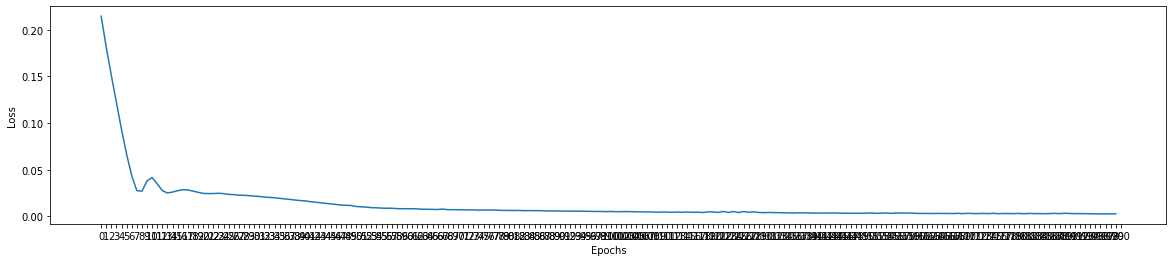

In [ ]:
losses_lstm = model.history.history['loss']
plt.figure(figsize=(20,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,201,1))
plt.plot(range(len(losses_lstm)),losses_lstm)

In [ ]:
scaled_test

array([[0.86771723, 1.01673893, 0.3592535 ],
       [0.71095729, 0.94619629, 0.42534992],
       [0.78222386, 0.88153099, 0.76749611],
       [0.59932253, 0.86587246, 1.04043546],
       [0.55929308, 0.91319379, 1.01010886],
       [0.64879234, 0.89458217, 0.65863142],
       [0.69066274, 0.86071537, 0.62752722],
       [0.40029455, 0.81608781, 0.72706065],
       [0.36661267, 0.81530993, 0.55287714],
       [0.58119293, 0.85845374, 0.53265941],
       [0.93824742, 0.90586151, 0.59253499],
       [1.18899853, 0.96727121, 0.39346812]])

In [ ]:
lstm_predictions_scaled = []

batch = scaled_train[-n_steps:]   # The last 12 observations in scaled_train
current_batch = batch.reshape((1, n_steps, n_features))

for i in range(len(test)):
  lstm_pred = model.predict(current_batch)[0]           # Predict values for tourism, currency, and temperature
  lstm_predictions_scaled.append(lstm_pred)
  imd_pred = np.append(lstm_pred, scaled_test[i][1:3])
  current_batch=np.append(current_batch[:,1:,:], [[imd_pred]], axis=1)

In [ ]:
lstm_predictions_scaled

[array([0.9707191], dtype=float32),
 array([0.8496591], dtype=float32),
 array([0.780139], dtype=float32),
 array([0.7504163], dtype=float32),
 array([0.7543902], dtype=float32),
 array([0.78307164], dtype=float32),
 array([0.7964469], dtype=float32),
 array([0.82490414], dtype=float32),
 array([0.76001287], dtype=float32),
 array([0.6668567], dtype=float32),
 array([0.4679225], dtype=float32),
 array([0.09569746], dtype=float32)]

In [ ]:
current_batch_reshaped = np.array(current_batch).reshape((n_steps, n_features))
current_batch_reshaped

array([[0.9707191 , 1.01673893, 0.3592535 ],
       [0.84965909, 0.94619629, 0.42534992],
       [0.78013903, 0.88153099, 0.76749611],
       [0.75041628, 0.86587246, 1.04043546],
       [0.75439018, 0.91319379, 1.01010886],
       [0.78307164, 0.89458217, 0.65863142],
       [0.79644692, 0.86071537, 0.62752722],
       [0.82490414, 0.81608781, 0.72706065],
       [0.76001287, 0.81530993, 0.55287714],
       [0.66685671, 0.85845374, 0.53265941],
       [0.46792251, 0.90586151, 0.59253499],
       [0.09569746, 0.96727121, 0.39346812]])

In [ ]:
lstm_predictions = scaler.inverse_transform(current_batch_reshaped)[:,0]
lstm_predictions

array([99972.82682514, 91752.85189009, 87032.44007087, 85014.26533318,
       85284.09322953, 87231.56416273, 88139.74583006, 90071.99136472,
       85665.87353802, 79340.57034707, 65832.93834186, 40558.85720184])

In [ ]:
test['LSTM_Tourists_Predictions'] = lstm_predictions
test

,tourists,average exchange rate (Convert 1 USD to Thai baht),average temperature - Bangkok (F),LSTM_Tourists_Predictions
Month,,,,
2016-01-01,92979,36.1284,81.17,99972.826825
2016-02-01,82335,35.6387,82.02,91752.851890
2016-03-01,87174,35.1898,86.42,87032.440071
2016-04-01,74755,35.0811,89.93,85014.265333
2016-05-01,72037,35.4096,89.54,85284.093230
2016-06-01,78114,35.2804,85.02,87231.564163
2016-07-01,80957,35.0453,84.62,88139.745830
2016-08-01,61241,34.7355,85.90,90071.991365
2016-09-01,58954,34.7301,83.66,85665.873538


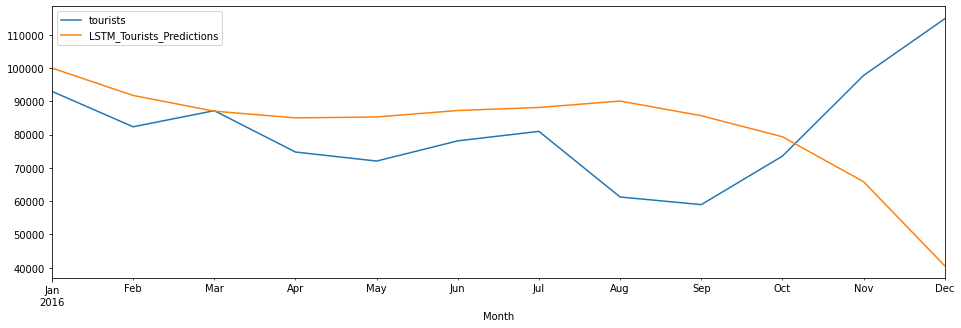

In [ ]:
test.tourists.plot(figsize = (16,5), legend = True)
test.LSTM_Tourists_Predictions.plot(legend = True)

In [ ]:
lstm_rmse_error = mean_squared_error(test.tourists, test.LSTM_Tourists_Predictions, squared=False)
lstm_mse_error = mean_squared_error(test.tourists, test.LSTM_Tourists_Predictions)
lstm_mape_error = mean_absolute_percentage_error(test.tourists, test.LSTM_Tourists_Predictions)

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAPE Error: {lstm_mape_error}')

MSE Error: 721864728.0153555
RMSE Error: 26867.54041618539
MAPE Error: 22.450945303770766
